In [1]:
import sys
import os
import torch
import cv2 as cv
import numpy as np
import torchvision
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import random
from torch.utils.data.sampler import SubsetRandomSampler
from skimage.io import imread, imshow

from PIL import Image

In [2]:
def HPF(image):
    kernel5x5 = np.array([[-1, -1, -1, -1, -1],
    [-1, 1, 2, 1, -1],
    [-1, 2, 4, 2, -1],
    [-1, 1, 2, 1, -1],
    [-1, -1, -1, -1, -1]])
    img = cv.filter2D(image, -1, kernel5x5)
    img = image - cv.GaussianBlur(image, (21,21), 0)
    #img = image - cv.medianBlur(image, 11, 0)
    return img

In [3]:
#'''
pi_cg_list = (list(), list())

num=0

for j in os.listdir('./data/PI2/'):
    if not j.startswith('.') and (j.split('.')[1] == 'jpg'):
        
        img = cv.imread('./data/PI2/' + str(j), 0)
        img = HPF(img)
        img = cv.merge((img, img, img))
        #print(img.shape)
        num+=1
        name = 'pi_' + str(num) + '.jpg'
        pi_cg_list[0].append(name)
        cv.imwrite('./data_processed2/PI2/' + str(name), img)
        
print(num)
print(len(pi_cg_list[0]))
#'''

800
800


In [4]:

#'''
num=0

for j in os.listdir('./data/CG/'):
    if not j.startswith('.') and (j.split('.')[1] == 'jpg'):
        
        img = cv.imread('./data/CG/' + str(j), 0)
        img = HPF(img)
        img = cv.merge((img, img, img))
        #print(img.shape)
        num+=1
        name = 'cg_' + str(num) + '.jpg'
        pi_cg_list[1].append(name)
        cv.imwrite('./data_processed2/CG/' + str(name), img)
        
print(num)
print(len(pi_cg_list[1]))
#'''

800
800


(224, 224, 3)


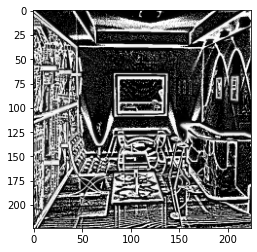

In [5]:
n = random.randint(0,799)
cg_image = cv.imread('./data_processed2/CG/cg_' + str(n) + '.jpg')
cg_image = cv.resize(cg_image, (224, 224), interpolation=cv.INTER_AREA)
print(cg_image.shape)

plt.imshow(cg_image, cmap='gray')

(224, 224, 3)


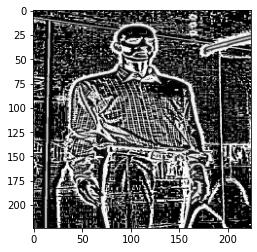

In [6]:
pi_image = cv.imread('./data_processed2/PI2/pi_' + str(n) + '.jpg')
pi_image = cv.resize(pi_image, (224, 224), interpolation=cv.INTER_AREA)
print(pi_image.shape)

plt.imshow(pi_image, cmap='gray')

Image shape:  224


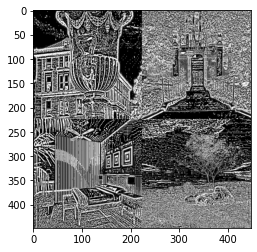

In [7]:
img_shape = 224
print('Image shape: ', img_shape)
root = './data_processed2'

final_img = None

labels = ['PI2', 'CG']

for i in range(2):
    row_img = None
    for j in range(2):
        
        imgpath = root + '/' + labels[i] + '/' + str(pi_cg_list[i][random.randint(1, 800)])
        #print(imgpath)
        img = cv.imread(imgpath)
        img = cv.resize(img, (img_shape, img_shape), interpolation = cv.INTER_AREA)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            
        if np.any(row_img == None):
            row_img = img
        else:
            row_img = np.hstack((row_img, img))
            
    if np.any(final_img == None):
            final_img = row_img
    else:
        final_img = np.vstack((final_img, row_img))  
                        
plt.imshow(final_img)
#cv.waitKey(0)
#cv.destroyAllWindows()        

<class 'numpy.ndarray'>


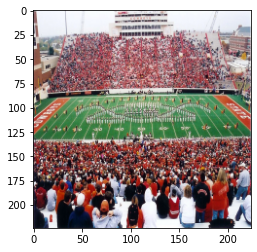

In [8]:
image = cv.imread('./data/PI/animal-selected-1.jpg')#/float(2**8)
print(type(image))
image = cv.resize(image, (224, 224), interpolation=cv.INTER_AREA)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = image/float(2**8)
plt.imshow(image)

c:\users\aakri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


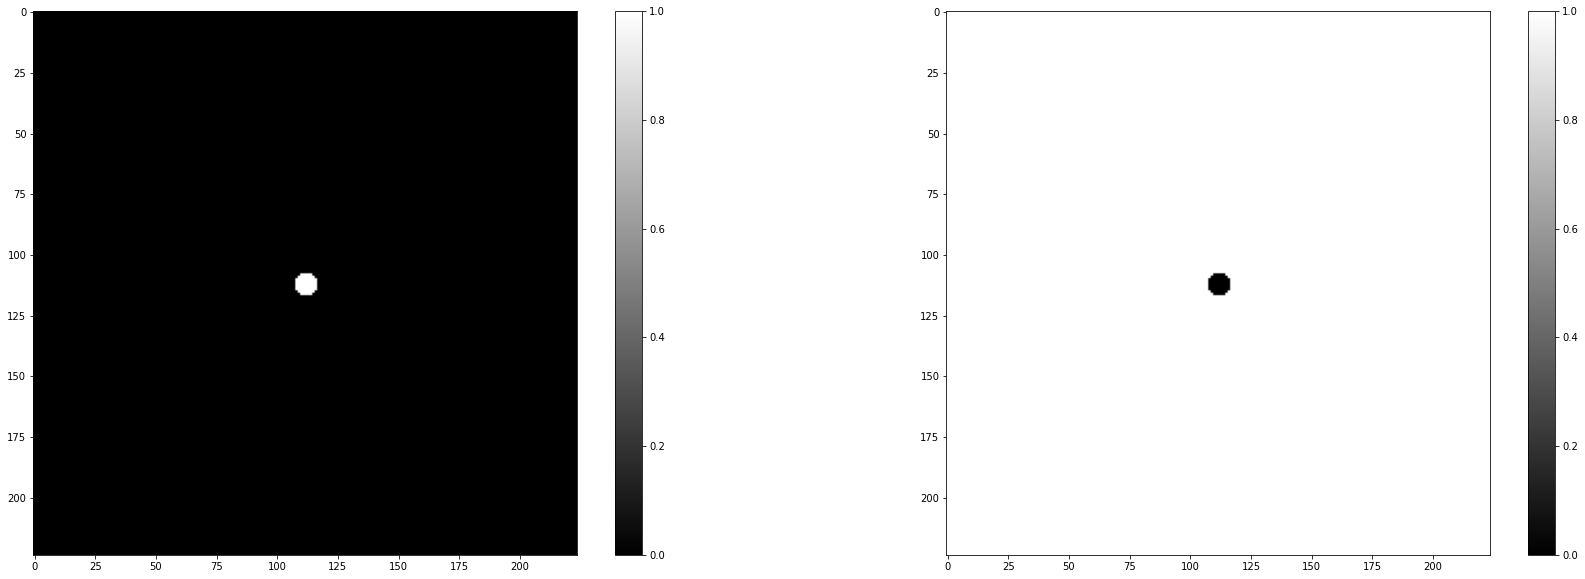

In [68]:
shape = (image.shape[:2])

def draw_cicle(shape,diamiter):
    '''
    Input:
    shape    : tuple (height, width)
    diameter : scalar
    
    Output:
    np.array of shape  that says True within a circle with diamiter =  around center 
    '''
    assert len(shape) == 2
    TF = np.zeros(shape,dtype=np.bool)
    center = np.array(TF.shape)/2.0

    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < diamiter **2
    return(TF)


TFcircleIN   = draw_cicle(shape=image.shape[:2],diamiter=5)
TFcircleOUT  = ~TFcircleIN

fig = plt.figure(figsize=(30,10))
ax  = fig.add_subplot(1,2,1)
im  = ax.imshow(TFcircleIN,cmap="gray")
plt.colorbar(im)
ax  = fig.add_subplot(1,2,2)
im  = ax.imshow(TFcircleOUT,cmap="gray")
plt.colorbar(im)
plt.show()

In [69]:
fft_img = np.zeros_like(image,dtype=complex)
for ichannel in range(fft_img.shape[2]):
    fft_img[:,:,ichannel] = np.fft.fftshift(np.fft.fft2(image[:,:,ichannel]))

In [70]:
def filter_circle(TFcircleIN,fft_img_channel):
    temp = np.zeros(fft_img_channel.shape[:2],dtype=complex)
    temp[TFcircleIN] = fft_img_channel[TFcircleIN]
    return(temp)

fft_img_filtered_IN = []
fft_img_filtered_OUT = []
## for each channel, pass filter
for ichannel in range(fft_img.shape[2]):
    fft_img_channel  = fft_img[:,:,ichannel]
    ## circle IN
    temp = filter_circle(TFcircleIN,fft_img_channel)
    fft_img_filtered_IN.append(temp)
    ## circle OUT
    temp = filter_circle(TFcircleOUT,fft_img_channel)
    fft_img_filtered_OUT.append(temp) 
    
fft_img_filtered_IN = np.array(fft_img_filtered_IN)
fft_img_filtered_IN = np.transpose(fft_img_filtered_IN,(1,2,0))
fft_img_filtered_OUT = np.array(fft_img_filtered_OUT)
fft_img_filtered_OUT = np.transpose(fft_img_filtered_OUT,(1,2,0))

In [71]:
abs_fft_img              = np.abs(fft_img)
abs_fft_img_filtered_IN  = np.abs(fft_img_filtered_IN)
abs_fft_img_filtered_OUT = np.abs(fft_img_filtered_OUT)

c:\users\aakri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


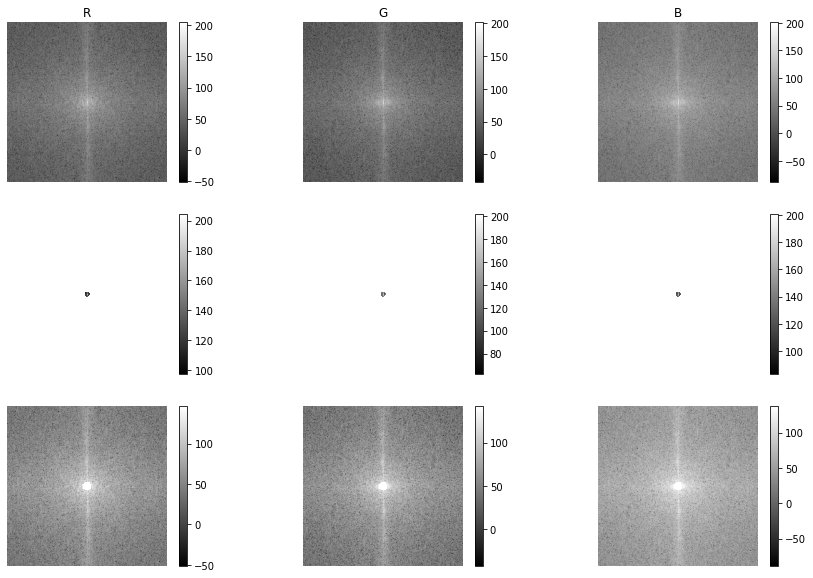

In [72]:
def imshow_fft(absfft):
    magnitude_spectrum = 20*np.log(absfft)
    return(ax.imshow(magnitude_spectrum,cmap="gray"))

fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(15,10))
fontsize = 15 
for ichannel, color in enumerate(["R","G","B"]):
    ax = axs[0,ichannel]
    ax.set_title(color)
    im = imshow_fft(abs_fft_img[:,:,ichannel])
    ax.axis("off")
    if ichannel == 0:
        ax.set_ylabel("original DFT",fontsize=fontsize)
    fig.colorbar(im,ax=ax)
    
    
    ax = axs[1,ichannel]
    im = imshow_fft(abs_fft_img_filtered_IN[:,:,ichannel])
    ax.axis("off")
    if ichannel == 0:
        ax.set_ylabel("DFT + low pass filter",fontsize=fontsize)
    fig.colorbar(im,ax=ax)
    
    ax = axs[2,ichannel]
    im = imshow_fft(abs_fft_img_filtered_OUT[:,:,ichannel])
    ax.axis("off")
    if ichannel == 0:
        ax.set_ylabel("DFT + high pass filter",fontsize=fontsize)   
    fig.colorbar(im,ax=ax)
    
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


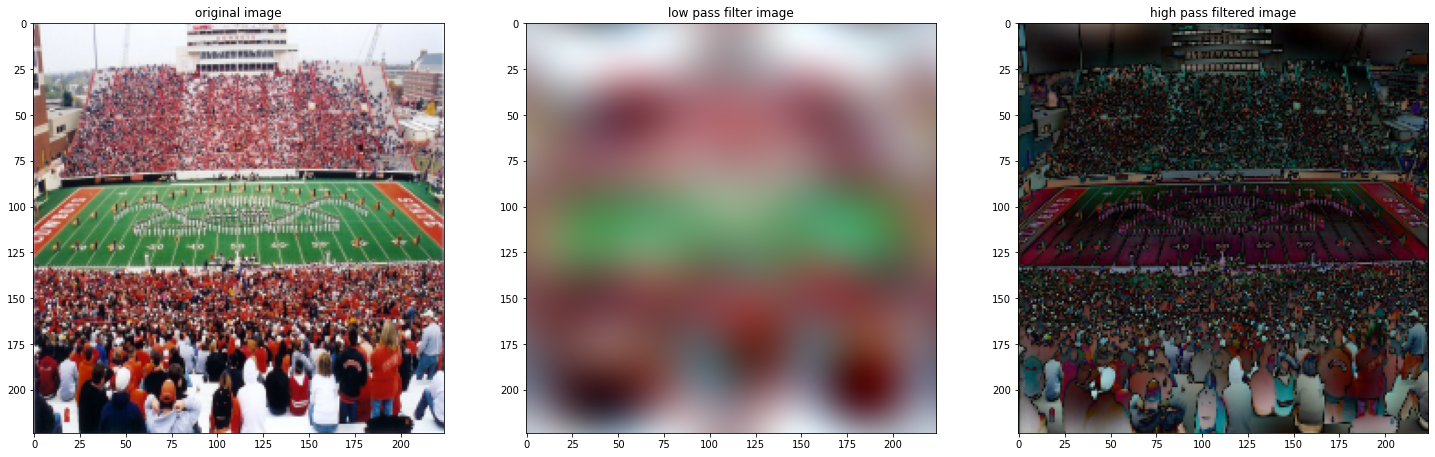

In [73]:
def inv_FFT_all_channel(fft_img):
    img_reco = []
    for ichannel in range(fft_img.shape[2]):
        img_reco.append(np.fft.ifft2(np.fft.ifftshift(fft_img[:,:,ichannel])))
    img_reco = np.array(img_reco)
    img_reco = np.transpose(img_reco,(1,2,0))
    return(img_reco)


img_reco              = inv_FFT_all_channel(fft_img)
img_reco_filtered_IN  = inv_FFT_all_channel(fft_img_filtered_IN)
img_reco_filtered_OUT = inv_FFT_all_channel(fft_img_filtered_OUT)

fig = plt.figure(figsize=(25,18))
ax  = fig.add_subplot(1,3,1)
ax.imshow(np.abs(img_reco))
ax.set_title("original image")

ax  = fig.add_subplot(1,3,2)
ax.imshow(np.abs(img_reco_filtered_IN))
ax.set_title("low pass filter image")


ax  = fig.add_subplot(1,3,3)
ax.imshow(np.abs(img_reco_filtered_OUT))
ax.set_title("high pass filtered image")
plt.show()

In [74]:
def HPF2(image):
    fft_img = np.zeros_like(image,dtype=complex)
    for ichannel in range(fft_img.shape[2]):
        fft_img[:,:,ichannel] = np.fft.fftshift(np.fft.fft2(image[:,:,ichannel]))
    
    fft_img_filtered_IN = []
    fft_img_filtered_OUT = []
    ## for each channel, pass filter
    for ichannel in range(fft_img.shape[2]):
        fft_img_channel  = fft_img[:,:,ichannel]
        ## circle IN
        temp = filter_circle(TFcircleIN,fft_img_channel)
        fft_img_filtered_IN.append(temp)
        ## circle OUT
        temp = filter_circle(TFcircleOUT,fft_img_channel)
        fft_img_filtered_OUT.append(temp) 

    fft_img_filtered_IN = np.array(fft_img_filtered_IN)
    fft_img_filtered_IN = np.transpose(fft_img_filtered_IN,(1,2,0))
    fft_img_filtered_OUT = np.array(fft_img_filtered_OUT)
    fft_img_filtered_OUT = np.transpose(fft_img_filtered_OUT,(1,2,0))
    
    abs_fft_img              = np.abs(fft_img)
    abs_fft_img_filtered_IN  = np.abs(fft_img_filtered_IN)
    abs_fft_img_filtered_OUT = np.abs(fft_img_filtered_OUT)
    
    img_reco              = inv_FFT_all_channel(fft_img)
    img_reco_filtered_IN  = inv_FFT_all_channel(fft_img_filtered_IN)
    img_reco_filtered_OUT = inv_FFT_all_channel(fft_img_filtered_OUT)
    return np.abs(img_reco_filtered_OUT)

<class 'numpy.ndarray'>


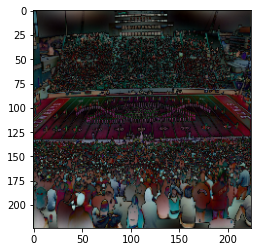

In [75]:
image = cv.imread('./data/PI/animal-selected-1.jpg')#/float(2**8)
print(type(image))
image = cv.resize(image, (224, 224), interpolation=cv.INTER_AREA)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = image/float(2**8)
plt.imshow(HPF2(image))

In [76]:
#'''
pi_cg_list2 = (list(), list())

num=0

for j in os.listdir('./data/PI2/'):
    if not j.startswith('.') and (j.split('.')[1] == 'jpg'):
        
        img = cv.imread('./data/PI2/' + str(j))
        img = cv.resize(img, (224, 224), interpolation=cv.INTER_AREA)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = img/float(2**8)
        img = HPF2(img)
        
        img = (255*img).astype(np.uint8)
        
        num+=1
        name = 'pi_' + str(num) + '.jpg'
        pi_cg_list2[0].append(name)
        cv.imwrite('./data_processed3/PI2/' + str(name), img)
        
print(num)
print(len(pi_cg_list2[0]))
#'''

800
800


In [77]:
#'''

num=0

for j in os.listdir('./data/CG/'):
    if not j.startswith('.') and (j.split('.')[1] == 'jpg'):
        
        img = cv.imread('./data/CG/' + str(j))
        img = cv.resize(img, (224, 224), interpolation=cv.INTER_AREA)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = img/float(2**8)
        img = HPF2(img)
        
        img = (255*img).astype(np.uint8)
        
        num+=1
        name = 'cg_' + str(num) + '.jpg'
        pi_cg_list2[1].append(name)
        cv.imwrite('./data_processed3/CG/' + str(name), img)
        
print(num)
print(len(pi_cg_list2[1]))
#'''

800
800


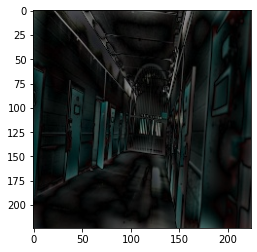

In [78]:
n = random.randint(0,799)
cg_image2 = cv.imread('./data_processed3/CG/cg_' + str(n) + '.jpg')

plt.imshow(cg_image2, cmap='gray')

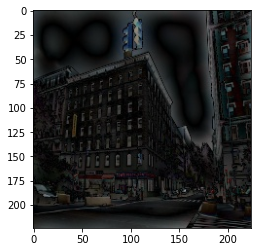

In [79]:
pi_image2 = cv.imread('./data_processed3/PI2/pi_' + str(n) + '.jpg')

plt.imshow(pi_image2, cmap='gray')